In [1]:
fname <- 'input_files/Met_all_gapfill.csv'
#header <- read.csv(fname, skip=3, nrows=1)
df <- read.csv(fname, header=TRUE)
#df[df==-9999] <- NA
#colnames(df) <- colnames(header)
tail(df)

,X,Date,Month,Day,Year,Sta,Avg_Temp,Max_Temp,Min_Temp,Avg_RH,Precip,Avg_VP,Avg_Wind_SP,Avg_Resultant_WindSP,Avg_Wind_Dir,Solar_Rad,Avg_Soil_Temp,Max_Soil_Temp,Min_Soil_Temp,Jul_Day,Max_Tempfill,Min_Tempfill,Avg_Tempfill
84040,84040,9/25/2015,9,25,2015,50,22.3,30.2,14.4,40.4,0,0.966,3.4,2.1,93.2,25.2,25.3,31.7,20.1,25Sep2015,30.2,14.4,22.3
84041,84041,9/26/2015,9,26,2015,50,22,31,13.1,33.1,0,0.863,2.9,1.5,182.2,25.2,26,32.1,20.9,26Sep2015,31,13.1,22
84042,84042,9/27/2015,9,27,2015,50,23.9,33.9,13.9,25.2,0,0.689,2.9,0.8,26.1,25.3,26.1,31.7,21.3,27Sep2015,33.9,13.9,23.9
84043,84043,9/28/2015,9,28,2015,50,24.6,33.4,15.8,21.9,0,0.622,2.7,1.9,16.9,24.9,25.9,31.8,20.7,28Sep2015,33.4,15.8,24.6
84044,84044,9/29/2015,9,29,2015,50,24.1,33.6,14.6,23.8,0,0.696,3.5,1.7,94.3,24.3,26.2,32.3,20.8,29Sep2015,33.6,14.6,24.1
84045,84045,9/30/2015,9,30,2015,50,26,31.9,20.2,28.9,0,0.912,5.7,4.8,162,22.2,27.1,31.8,23.4,30Sep2015,31.9,20.2,26


In [23]:
df_x <- subset(df, subset=Sta==50)
df_x$Jul_Day <- 0 # string, get rid of it
# Calculate PET
#df_sta$PET <- thornthwaite(df_sta$Avg_Temp, lat[i], na.rm=T)
sum(is.na(df_x$Min_temp))
#df_x$PET_penman <- penman(df_x$Min_temp, df_x$Max_temp, df_x$Avg_Wind_SP, lat=lat[i])

Warning message:
In is.na(Tmin): is.na() applied to non-(list or vector) of type 'NULL'Warning message:
In is.na(Tmax): is.na() applied to non-(list or vector) of type 'NULL'

ERROR: Error in penman(df_x$Min_temp, df_x$Max_temp, df_x$Avg_Wind_SP, lat = lat[i]): Error: Data must not contain NAs


           station_40
1988-01-31         NA
1988-02-29         NA
1988-03-31         NA
1988-04-30         NA
1988-05-31         NA
1988-06-30   1.985985


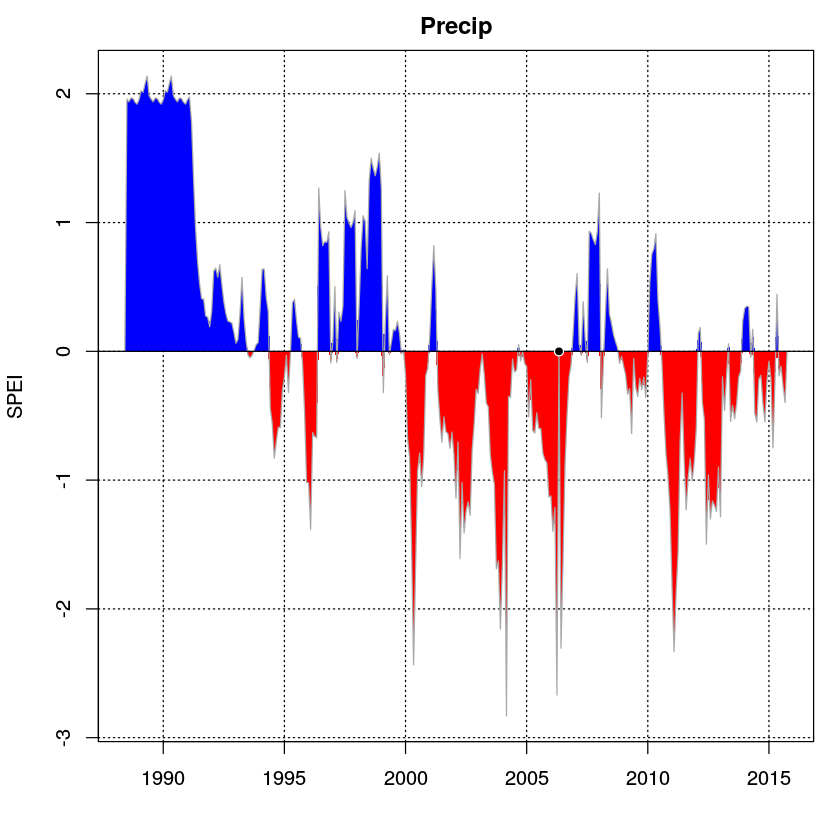

           station_42
1989-02-28         NA
1989-03-31         NA
1989-04-30         NA
1989-05-31         NA
1989-06-30         NA
1989-07-31   2.105125


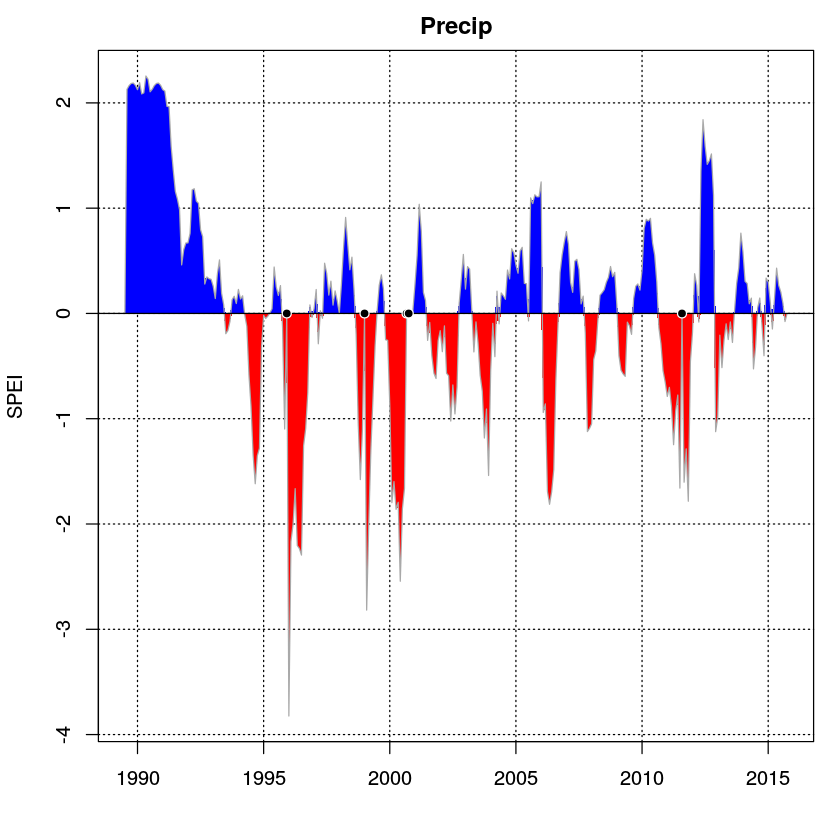

           station_49
1999-01-31         NA
1999-02-28         NA
1999-03-31         NA
1999-04-30         NA
1999-05-31         NA
1999-06-30  0.4203036


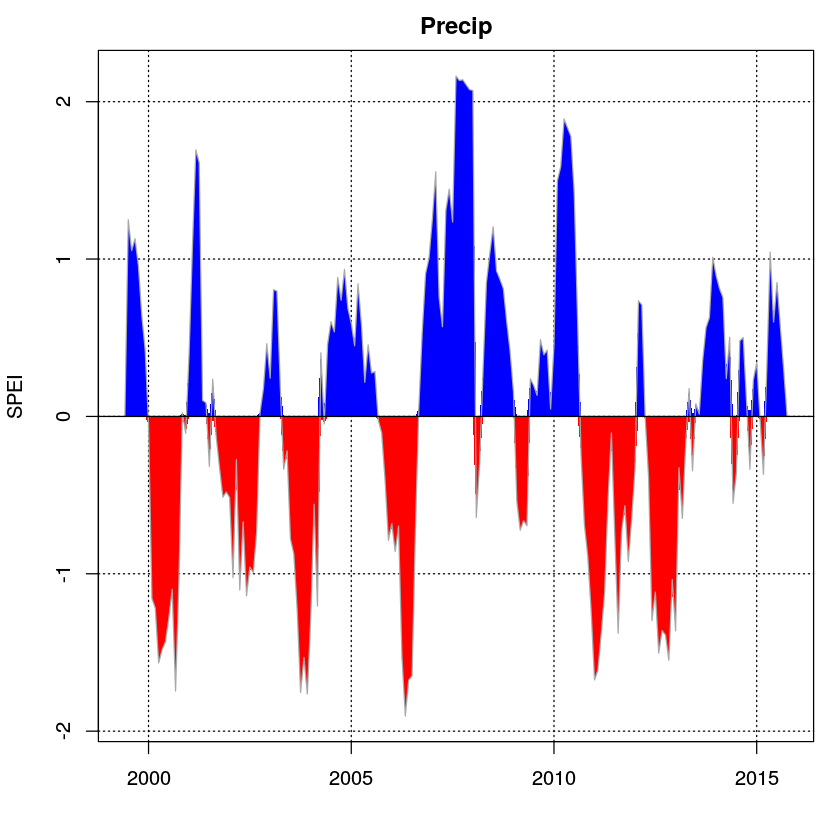

           station_50
2002-01-31         NA
2002-02-28         NA
2002-03-31         NA
2002-04-30         NA
2002-05-31         NA
2002-06-30 -0.7675368


[1] 334

[1] 333

[1] 334
[1] 340


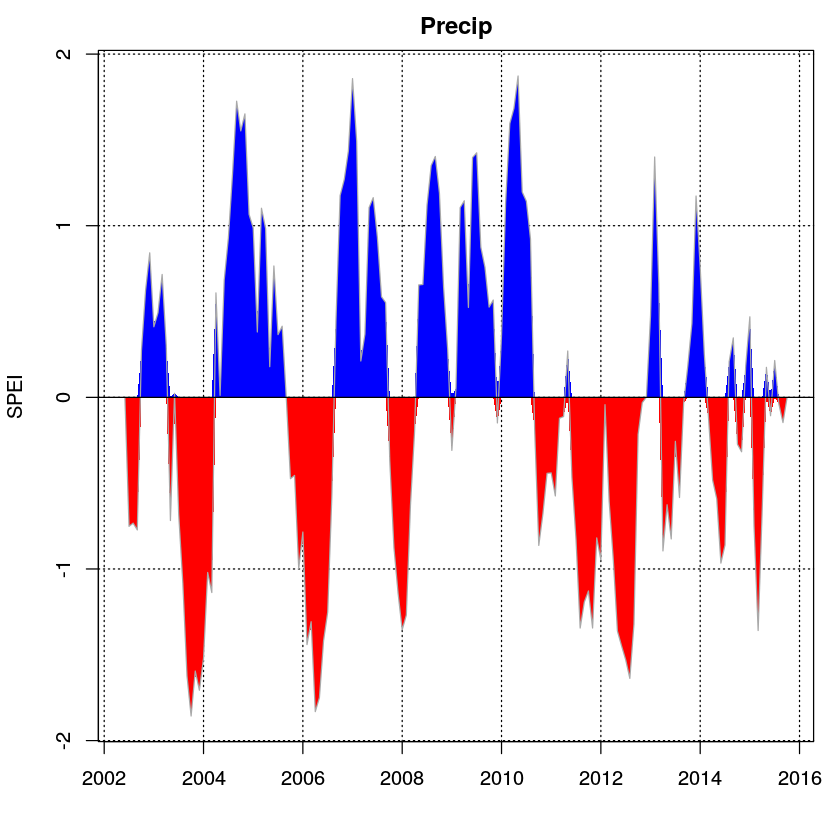

In [12]:
library('SPEI')
library('xts')

# Integration period for SPEI (in months)
int_months <- 6
# First part of outfile
outfile <- paste("SPEI_penman_", as.character(int_months), "mo_Sev", sep='')

station <- c(40, 42, 49, 50)
lat <- c(34.3592, 34.368, 34.3331, 34.3348)

for (i in 1:4){
    df_sta <- subset(df, subset=Sta==station[i])
    df_sta$Jul_Day <- 0 # string, get rid of it
    # Calculate PET
    df_sta$PET <- thornthwaite(df_sta$Avg_Temp, lat[i], na.rm=T)
    #df_sta$PET_penman <- penman(df_sta$Min_temp, df_sta$Max_temp, df_sta$Avg_Wind_SP, Ra=df_sta$Solar_Rad, lat=lat[i])
    # Make a timeseries and get starting year and month
    df_xts <- xts(df_sta[,3:ncol(df_sta)], order.by=as.Date(df_sta$Date, "%m/%d/%Y"))
    startmon <- as.numeric(as.yearmon(index(df_xts[1])))
    startyr <- floor(startmon)
    startmon <- ceiling((startmon-startyr)*12) + 1
    # Calculate climatic water difference and then SPEI
    cwdiff <- apply.monthly(df_xts$Precip, FUN=sum) - apply.monthly(df_xts$PET, FUN=sum)
    #print(startyr)
    #print(startmon)
    spei_sta <- spei(ts(cwdiff, frequency=12, start=c(startyr, startmon)), int_months, na.rm=TRUE)
    plot(spei_sta)
    spei_sta <- xts(as.vector(spei_sta$fitted),  index(cwdiff))
    colnames(spei_sta) <- paste('station_', as.character(station[i]), sep='')
    # 
    print(head(spei_sta))
    if (i==1){
        df_new <- spei_sta
    } else if (i > 1) {
        df_new <- cbind(df_new, spei_sta)
    }
}

# Somehow a funky entry at 2009-2-12 is created, remove
nrow(df_new)
df_new <- df_new[c('::2009-01-31', '2009-02-28::')]
nrow(df_new)

# There may be both infinite and NA values in the output
# Convert -Inf to NA
print(sum(is.na(df_new)))
df_new[!is.finite(df_new)] <- NA
print(sum(is.na(df_new)))

#print(tail(df_new))
write.zoo(df_new, file = paste(outfile, '.csv', sep=''),
          index.name = "Date", sep=',', row.names = FALSE, col.names=TRUE)

# Interpolate over NA values
df_new <- na.approx(df_new)

write.zoo(df_new, file = paste('../processed_data/Sev_SPEI/', outfile, '_NAinterp.csv', sep=''),
          index.name = "Date", sep=',', row.names = FALSE, col.names=TRUE)

In [37]:
#?as.Date
as.Date('01-02-1997', "%d-%m-%Y")
df_xts <- xts(df_sta[,3:ncol(df_sta)], order.by=as.Date(df_sta$Date, "%m/%d/%Y"))
head(df_xts)
cwdiff <- apply.monthly(df_xts$Precip, FUN=sum) - apply.monthly(df_xts$PET, FUN=sum)
head(cwdiff)
#plot(df_sta$PET)

[1] "1997-02-01"

           Month Day Year Sta Avg_Temp Max_Temp Min_Temp Avg_RH Precip Avg_VP
2002-01-26     1  26 2002  50      4.4     14.3     -5.6   25.9      0  0.208
2002-01-27     1  27 2002  50      8.3     16.9     -0.2   29.9      0  0.348
2002-01-28     1  28 2002  50     11.6     15.7      7.6   25.1      0  0.323
2002-01-29     1  29 2002  50      6.5      9.2      3.7   59.6      0  0.575
2002-01-30     1  30 2002  50      3.1      7.7     -1.4   68.5      0  0.535
2002-01-31     1  31 2002  50     -3.2      3.4     -9.9   58.1      0  0.275
           Avg_Wind_SP Avg_Resultant_WindSP Avg_Wind_Dir Solar_Rad
2002-01-26         3.1                  2.7        181.6      15.6
2002-01-27         2.9                  2.3        187.8      11.4
2002-01-28         4.1                  3.6        199.8       6.6
2002-01-29         5.3                  5.0        179.0       2.8
2002-01-30         4.3                  3.4        198.2       7.3
2002-01-31         2.7                  1.6        3

                Precip
2002-01-31   -89.49704
2002-02-28  -386.49384
2002-03-31  -959.12389
2002-04-30 -2257.56989
2002-05-31 -2820.94844
2002-06-30 -4186.80729

[1] 3

              Jan          Feb          Mar          Apr          May
1999           NA           NA           NA           NA           NA
2000 -0.344152180 -0.272540439 -0.134263533  0.472594690  0.135766139
2001 -1.605820638 -1.582848904 -1.812497453 -1.408059337 -1.173399995
2002  1.493786611  1.314444991  1.565375547  1.384209432  1.331023323
2003 -0.295475166 -0.442689251 -0.553749590 -1.172872354 -1.292268688
2004  0.454543251  0.695265008  0.478123728  0.986704062  1.413668794
2005 -0.290037693 -0.181879964  0.185015352 -0.191071589 -0.299926791
2006  0.752172665  1.178311782  1.395536497  1.288491291  0.759255154
2007  1.484456472  1.491823404  1.274803877  1.216738225  1.252467341
2008  0.676364006  0.532657226 -0.104464887 -0.565397715 -0.309495843
2009 -1.326552942 -1.386183462 -1.155353943 -1.219230728 -1.591870015
2010 -1.026142658 -0.875507373 -0.648015498 -0.424432441 -0.273710629
2011  0.366944167 -0.270049661  0.005722305  0.060334575  0.071020922
2012 -0.399517706 -0

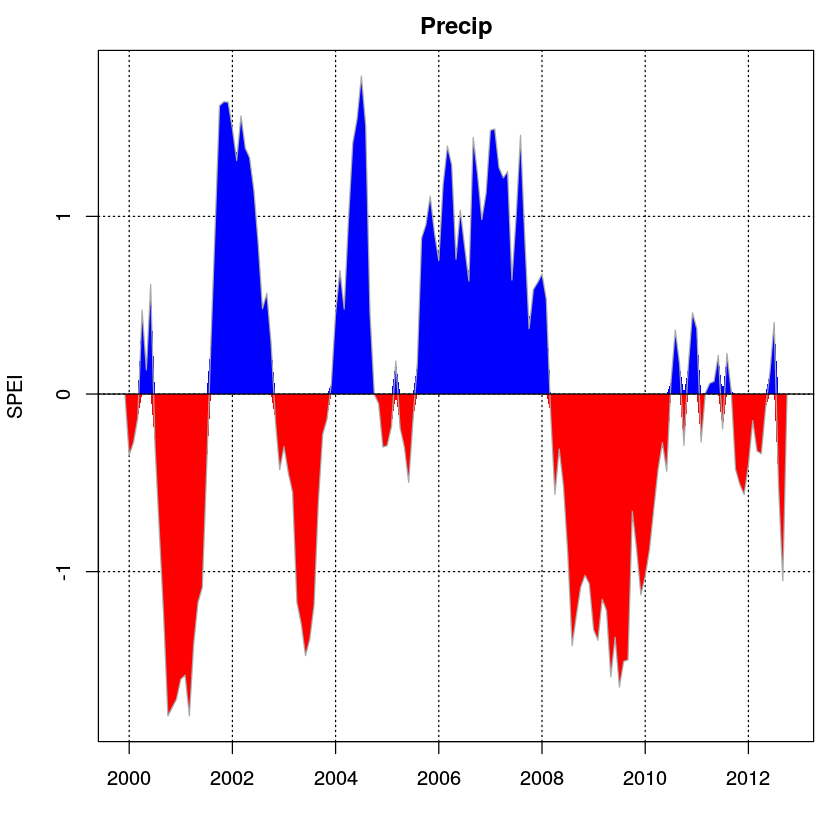

In [44]:
sum(is.na(cwdiff))
spei_sta <- spei(ts(cwdiff, frequency=12, start=c(1999, 1) ), 12, na.rm=TRUE )
print(spei_sta$fitted)
print(as.vector(spei_sta$fitted))
str(spei_sta)
plot(spei_sta)